In [1]:
#Alex Netzley
#2/18/2024


import os
import numpy as np
import pandas as pd
import openpyxl
from openpyxl import load_workbook
import matplotlib.pyplot as plt
from scipy import stats

Loading in the Datasets

In [2]:
#Loading in the data
data_folder = os.path.join(os.path.dirname(os.getcwd())+'/data/')
#Read in Yelp Data
yelp_data = pd.read_csv(os.path.join(data_folder, 'yelp_Processed.csv'))

Performing Preliminary EDA

In [3]:
#Preliminary EDA

print(len(yelp_data))

#Extract average number of reviews
print(np.mean(yelp_data['Num Reviews']))
print(np.mean(yelp_data['Rating'].astype('Float32')))

2592
354.6253858024691
3.8333204


<Axes: ylabel='Primary Tag'>

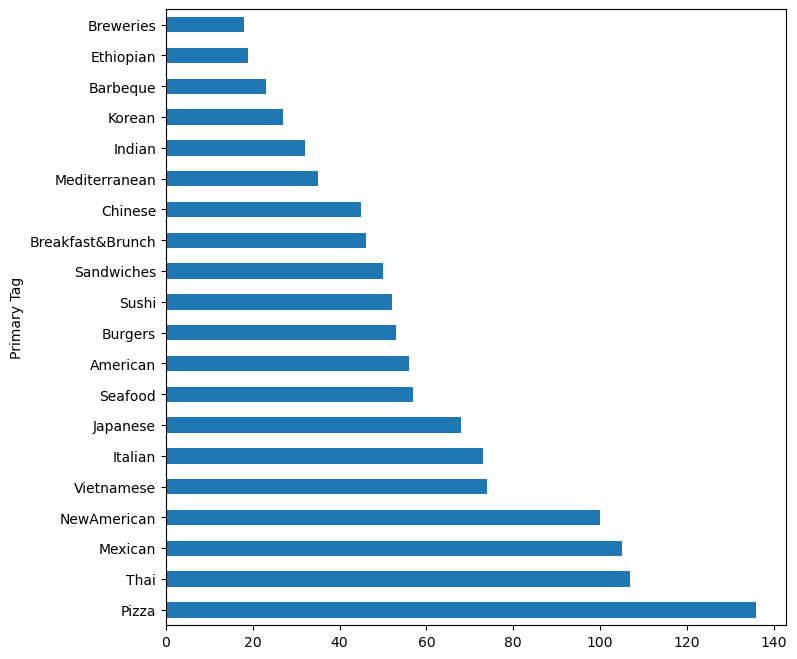

In [7]:
#Extracting the primary tag
tags = yelp_data["Tags"].replace('[\[\]\"\' ]', '', regex=True)
p_tags = []
for row in tags:
    p_tags.append(row.split(',')[0])

yelp_data['Primary Tag'] = p_tags
yelp_data.loc[yelp_data["Primary Tag"] == 'SushiBars', 'Primary Tag'] = "Sushi"

cat_counts = (yelp_data['Primary Tag'].value_counts())
cat_counts.plot(kind = 'barh')

# Filter to restuarants with at least 50 Reviews (this remes)
yelp_data = yelp_data[yelp_data['Num Reviews'] >=50]

# Filter to Types with at least 20 entries
filt_yelp = yelp_data[yelp_data['Primary Tag'].isin(cat_counts[cat_counts >= 20].index)]

#Excluding all non-food restuarants
exclude_list = ['Bakeries', 'Delis','SportsBars', 'DiveBars', 'IceCream&FrozenYogurt', 'Cafes', 'Pubs', 'CocktailBars', 'FastFood', 'Bars', 'Coffee&Tea', 'Donuts']

filt_yelp = filt_yelp[~filt_yelp['Primary Tag'].isin(exclude_list)]


cat_counts = (filt_yelp['Primary Tag'].value_counts())
cat_counts.plot(kind = 'barh', figsize = (8, 8))

#At this point we have 21 cuisines

<Axes: ylabel='Primary Tag'>

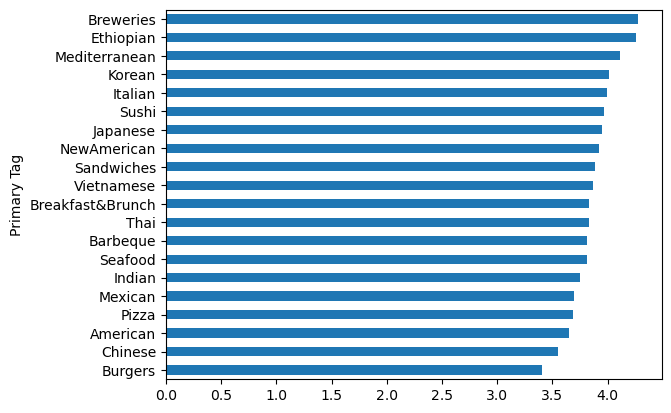

In [8]:
#Plot average rating of these most common cuisines
average_rating = (filt_yelp.groupby('Primary Tag')['Rating'].mean()).sort_values()#.tail(5)
average_rating.plot(kind='barh')

In [9]:
#Calculate SD of these most common cuisines
std_rating = (filt_yelp.groupby('Primary Tag')['Rating'].std()).sort_values()#.tail(5)
se_rating = std_rating/np.sqrt(cat_counts)
avg_rating_upper = average_rating + 1.96*se_rating
avg_rating_lower = average_rating - 1.96*se_rating

In [10]:
combined_analysis_df = pd.concat([average_rating, avg_rating_upper, avg_rating_lower, cat_counts], axis = 1)
filtered_combined_analysis = combined_analysis_df[combined_analysis_df["Rating"] > 3.93]

Construct Confidence Intervals

Text(0.5, 1.0, 'Average Rating with 95% Confidence Interval for the Top 5 Cuisines')

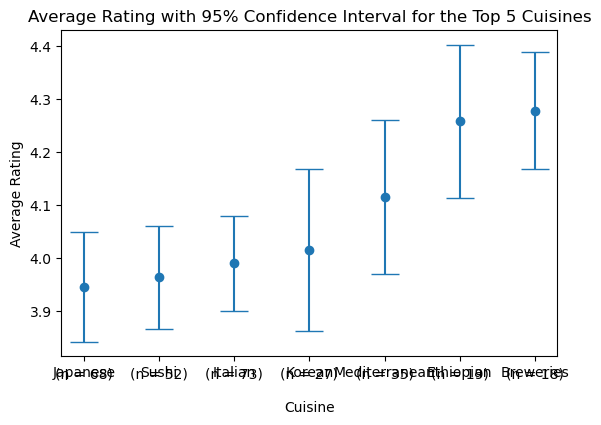

In [11]:
plt.errorbar(filtered_combined_analysis.index, 
             filtered_combined_analysis["Rating"], 
             yerr = [filtered_combined_analysis["Rating"] - filtered_combined_analysis[1], filtered_combined_analysis[0] - filtered_combined_analysis["Rating"]],
            fmt='o',
            capsize=10,
            linestyle='None' )
plt.xticks(filtered_combined_analysis.index, filtered_combined_analysis.index)
plt.xlabel("Cuisine", labelpad=15)
plt.ylabel("Average Rating")
plt.subplots_adjust(bottom=0.2)

counts = filtered_combined_analysis["count"].apply(lambda x: f"(n = {x})")
for i, count in enumerate(counts):
    plt.text(filtered_combined_analysis.index[i], 3.773, count, ha='center')

plt.title('Average Rating with 95% Confidence Interval for the Top 5 Cuisines')

Perform Pairwise T-Tests with Bonferroni Correction

In [12]:

yelp_data_medi = filt_yelp[filt_yelp['Tags'].str.contains("Medi", na=False)]
medi = (yelp_data_medi['Rating']).to_numpy().astype(float)

yelp_data_korean = filt_yelp[filt_yelp['Tags'].str.contains("Korean", na=False)]
korean = (yelp_data_korean['Rating']).to_numpy().astype(float)

yelp_data_italian = filt_yelp[filt_yelp['Tags'].str.contains("Italian", na=False)]
italian = yelp_data_italian['Rating'].to_numpy().astype(float)

yelp_data_sushi = filt_yelp[filt_yelp['Tags'].str.contains("Sushi", na=False)]
sushi = yelp_data_sushi['Rating'].to_numpy().astype(float)

yelp_data_japanese = filt_yelp[filt_yelp['Tags'].str.contains("Japan", na=False)]
japanese = yelp_data_japanese['Rating'].astype('Float32').to_numpy().astype(float)


#Perform T-Tests
t_stats = []
p_values = []
for opp in [korean, italian, sushi, japanese]:
    t_stat, p_value = stats.ttest_ind(medi, opp, equal_var=False, alternative='greater')
    t_stats.append(t_stat)
    p_values.append(p_value)
